In [1]:
import numpy as np

import librosa
import librosa.display

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torch.nn.functional as F
import torchaudio
from torchaudio.models import WaveRNN

from torchvision.utils import make_grid 
import matplotlib.pyplot as plt    
import os
import random
from tqdm import tqdm 

In [2]:
torch.version.cuda
print(torch.version.cuda)
torch.cuda.is_available() # True

11.8


True

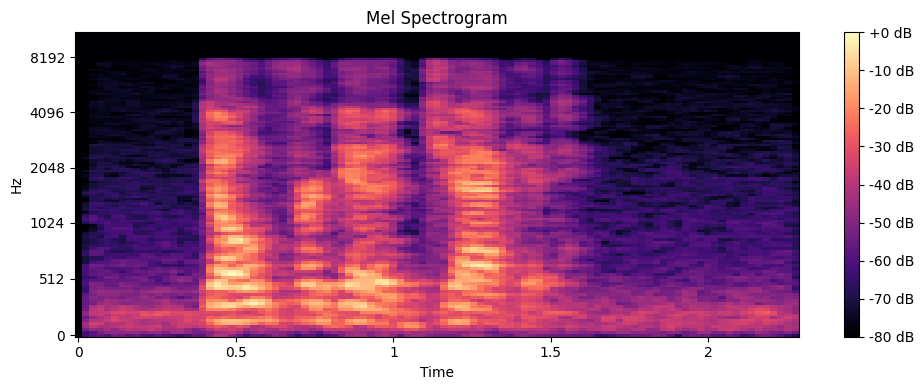

In [3]:
#Visualising the data

crema_d_spec_path = './AudioWAV/1001_DFA_ANG_XX.wav'
y, sr = librosa.load(crema_d_spec_path)

# Compute the spectrogram
spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)

# Convert to decibel scale (log scale)
spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()

In [4]:
waveform, sample_rate = torchaudio.load(crema_d_spec_path)
print(waveform.size(), sample_rate)

torch.Size([1, 36409]) 16000


In [5]:
#calculation
mw = 0
ms = 0
max_waveform_length = 314818
directory = './ALL'
for filename in os.listdir(directory):
    if filename.endswith('.wav'):
        
        filepath = os.path.join(directory, filename)
        
        
        # Load audio waveform
        waveform, sr = torchaudio.load(filepath)

        waveform_length = waveform.size(1)
        if waveform_length < max_waveform_length:
            padding = torch.zeros(1, max_waveform_length - waveform_length)
            waveform = torch.cat([waveform, padding], dim=1)
        elif waveform_length > max_waveform_length:
            waveform = waveform[:, :max_waveform_length]
        
        # # Compute spectrogram
        mel_spec_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_mels=64, n_fft=1024, hop_length=160)
        spectrogram = mel_spec_transform(waveform)

        mw = max(mw, waveform.size(1))
        ms = max(ms, spectrogram.size(2))

print(mw)
print(ms)  

314818
1968


In [6]:
#calculation
mw = 0
ms = 0
max_waveform_length = 314818
directory = './ALL'
for filename in os.listdir(directory):
    if filename.endswith('.wav'):
        
        filepath = os.path.join(directory, filename)
        
        
        # Load audio waveform
        waveform, sr = torchaudio.load(filepath)

        waveform_length = waveform.size(1)
        if waveform_length < max_waveform_length:
            padding = torch.zeros(1, max_waveform_length - waveform_length)
            waveform = torch.cat([waveform, padding], dim=1)
        elif waveform_length > max_waveform_length:
            waveform = waveform[:, :max_waveform_length]
        
        # # Compute spectrogram
        mel_spec_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_mels=64, n_fft=1024, hop_length=160)
        spectrogram = mel_spec_transform(waveform)

        mw = max(mw, waveform.size(1))
        ms = max(ms, spectrogram.size(2))

print(mw)
print(ms)  

314818
1968


In [7]:

def get_label(type, filename):

    if(type == 'save'):
        if filename[-8:-6]=='_a':
            return 'ANG'
        elif filename[-8:-6]=='_d':
            return 'DIS'
        elif filename[-8:-6]=='_f':
            return 'FEA'
        elif filename[-8:-6]=='_h':
            return 'HAP'
        elif filename[-8:-6]=='_n':
            return 'NEU'
        elif filename[-8:-6]=='sa':
            return 'SAD'
        elif filename[-8:-6]=='su':
            return 'SU'
        else:
            return ''
    
    elif(type == 'crema_d'):
        return filename.split('_')[2]

    elif(type == 'ravdess'):
        part = filename.split('.')[0].split('-')
        emotion = int(part[2])
        if emotion == 1 or emotion == 2:
            return 'NEU'
        elif emotion == 3:
            return 'HAP'
        elif emotion == 4:
            return 'SAD'
        elif emotion == 5:
            return 'ANG'
        elif emotion == 6:
            return 'FEA'
        elif emotion == 7:
            return 'DIS'
        elif emotion == 8:
            return 'SU'

    elif(type == 'tess'):
        i = filename.split('_')[2]

        if i == 'angry':
            return 'ANG'
            
        elif i == 'disgust':
            return 'DIS'
            
        elif i == 'fear':
            return 'FEA'
            
        elif i == 'happy':
            return 'HAP'
            
        elif i == 'neutral':
            return 'NEU'
                                        
        elif i == 'ps':
            return 'SU'

        elif i == 'sad':
            return 'SAD'
            
    return ''

#for ravdess and tess
def load_other(directory, type):

    dir_list = os.listdir(diectory)
    dir_list.sort()
    emotion = []

    for i in dir_list:
        fname = os.listdir(directory + i)
        d = load_dataset(fname, type, 314818, 1968)
    return d

def load_dataset(directory, type, max_waveform_length, max_spec_len):
    dataset = []
    # emotion_to_number = {'NEU': 0, 'HAP': 1, 'SAD': 2, 'ANG': 3, 'DIS': 4, 'FEA': 5, 'SU':6}
    emotion_to_number = {'NEU': 0, 'HAP': 1, 'SAD': 2, 'ANG': 3, 'DIS': 4, 'FEA': 5}
    max_len = 0
    
    # Iterate through files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.wav'):
            
            filepath = os.path.join(directory, filename)
            emotion = get_label(type,filename)
            emotion_no = emotion_to_number[emotion]
            emotion_label = torch.zeros(6)
            emotion_label[emotion_no] = 1
            
            # Load audio waveform
            waveform, sr = torchaudio.load(filepath)
            
            # waveform_length = waveform.size(1)
            # if waveform_length < max_waveform_length:
            #     padding = torch.zeros(1, max_waveform_length - waveform_length)
            #     waveform = torch.cat([waveform, padding], dim=1)
            # elif waveform_length > max_waveform_length:
            #     waveform = waveform[:, :max_waveform_length]
            
            # Compute spectrogram
            mel_spec_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_mels=128, n_fft=1024, hop_length=256)
            # mel_spec_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_mels=64, n_fft=1024, hop_length=160)
            spectrogram = mel_spec_transform(waveform)
            
            # Pad or truncate spectrogram to max_spec_len
            # spec_len = spectrogram.size(2)
            # if spec_len < max_spec_len:
            #     padding = torch.zeros(1, 80, max_spec_len - spec_len)  # Add a new axis
            #     spectrogram = torch.cat([spectrogram, padding], dim=2)

            # elif spec_len > max_spec_len:
            #     spectrogram = spectrogram[:, :, :max_spec_len]
            
            
            epsilon = 1e-10
            spec_db = 10 * torch.log10(spectrogram + epsilon)
            
            dataset.append((spec_db, emotion_label))

    return dataset


def split_dataset(dataset, batch_size, train_ratio=0.9):

    # Split dataset into training and testing sets
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoader objects for training and testing sets
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_dataset, test_dataset, train_dataloader, test_dataloader

In [8]:
crema_d_path = './AudioWAV'

# data_crema = load_dataset(crema_d_path, 'crema_d', 80080, 500)
data_crema = load_dataset(crema_d_path, 'crema_d', 80080, 500)

dataset = data_crema

print(len(dataset))


7442


In [9]:
train_dataset, test_dataset, train_dataloader, test_dataloader = split_dataset(dataset, 1)

In [10]:
print(len(dataset))
for batch_idx, (s, l) in enumerate(train_dataloader):
    print(s.size())
    print(l.size())
    break


7442
torch.Size([1, 1, 128, 182])
torch.Size([1, 6])


In [11]:
 class RNN(nn.Module):
     def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.2):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)  # Add softmax layer
    
     def forward(self, x):
        # Flatten the spectrogram data along the frequency_bins dimension
        
        x = x.view(x.size(0), -1, x.size(3))  # [batch_size, channels * frequency_bins, time_steps]
        x = torch.permute(x,(0,2,1))
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda()
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out) 
        out = self.fc(out)
        out = self.softmax(out)
        return out
        
        # Only take the output from the last time step
      #   out = self.softmax(self.fc1(out[:, -1, :]))  # [batch_size, num_classes]
      #   out = self.softmax(self.fc2(out))  # Apply softmax activation
      #   return out

In [12]:
def training(model, loss_function, optimizer, train_dataloader, n_epochs, update_interval):
    # model.train()
    losses = []

    for n in range(n_epochs):
        for i, (specgram, label) in enumerate(tqdm(iter(train_dataloader))):
            specgram, label = specgram.cuda(), label.cuda()
            optimizer.zero_grad()
            pred = model(specgram)
            label = label.long() 
            loss = loss_function(pred, label) #err incompatible tensoor dimensions
            losses.append(loss.item())
            loss.backward()
            optimizer.step()

            if i % update_interval == 0:
                losses.append(round(loss.item(), 2)) # This will append your losses for plotting -- please use "loss" as the name for your loss
        
    return model, losses

In [14]:
batch_size = 1
lr = 1e-4
n_epochs = 20
input_size = 128  # input size after flattening the spectrogram
hidden_size = 512  # size of the hidden state
num_layers = 6  # number of LSTM layers
num_classes = 6  # number of output classes
update_interval = 10

train_dataset, test_dataset, train_dataloader, test_dataloader = split_dataset(dataset, batch_size)

# Initialize the LSTM model
model = RNN(input_size, hidden_size, num_layers, num_classes)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

model, losses = training(model.cuda(), loss_function, optimizer, train_dataloader,n_epochs, update_interval)
print(losses)

100%|██████████| 6697/6697 [05:08<00:00, 21.74it/s]

[4.897846698760986, 4.9, 5.056217670440674, 4.983548641204834, 5.379820346832275, 5.192823886871338, 5.203824996948242, 5.043156623840332, 4.98329496383667, 4.969384670257568, 5.003390789031982, 4.778196334838867, 4.78, 5.016305923461914, 5.331960678100586, 5.145872592926025, 5.179576396942139, 5.1564459800720215, 4.861330509185791, 4.9546990394592285, 5.032589435577393, 5.079158782958984, 5.345332622528076, 5.35, 5.339837551116943, 4.5451178550720215, 4.92266321182251, 4.946892261505127, 4.791499614715576, 5.001672267913818, 4.682036876678467, 5.289985656738281, 5.026736736297607, 4.989348888397217, 4.99, 4.912936687469482, 4.725636959075928, 4.55798864364624, 4.795674800872803, 4.67528772354126, 4.6707892417907715, 4.778891563415527, 4.4436492919921875, 4.385674953460693, 4.753423690795898, 4.75, 4.737503528594971, 4.4708662033081055, 4.506414413452148, 4.916356086730957, 4.806337356567383, 4.403072834014893, 4.779438018798828, 4.378906726837158, 4.727072238922119, 4.280853271484375,

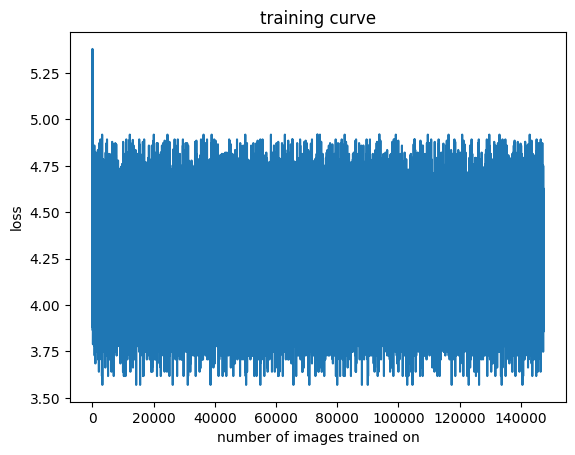

In [15]:
plt.plot(np.arange(len(losses)) * batch_size * 1, losses)
plt.title("training curve")
plt.xlabel("number of images trained on")
plt.ylabel("loss")
plt.show()

In [16]:
def test_accuracy(model, loss_function, test_data):

    '''
    This function will test the given model on the given test_data
    it will return the accuracy and the test loss (given by loss_function) 
    '''
    
    sum_loss = 0
    n_correct = 0
    total = 0

    for i, (spec, label) in enumerate(tqdm(iter(test_data))):

        # This is essentially exactly the same as the training loop 
        # without the, well, training, part (and we record the accuracy too)
        spec,label=spec.cuda(),label.long().cuda()
        pred = model(spec)
        loss = loss_function(pred, label)
        sum_loss += loss.item()

        _, predicted = torch.max(pred,1)
        _, label = torch.max(label,1)
        n_correct += (predicted == label).sum()
        total += label.size(0)
    
    test_acc = round(((n_correct / total).item() * 100), 2)
    avg_loss = round(sum_loss / len(test_data), 2)

    print("test accuracy:", test_acc)
    print("test loss:", avg_loss )
    #test

    return test_acc, avg_loss

In [17]:
# To see how well your model is doing without hyperpameter tuning

print("testing the previously trained model")
test_acc,avg_loss = test_accuracy(model.cuda(), loss_function, test_dataloader)

print("Testing accuracy of your first model:", test_acc)
print("Average loss of your first model:", avg_loss)

testing the previously trained model


100%|██████████| 745/745 [00:16<00:00, 45.98it/s]

test accuracy: 85.37
test loss: 4.24
Testing accuracy of your first model: 85.37
Average loss of your first model: 4.24
